Found 4447 images belonging to 5 classes.
Found 586 images belonging to 5 classes.


C:\Users\Shivani\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.4443 - loss: 3.9312 - val_accuracy: 0.6724 - val_loss: 2.0917 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7232 - loss: 1.8508 - val_accuracy: 0.7065 - val_loss: 1.4561 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7794 - loss: 1.2719 - val_accuracy: 0.7474 - val_loss: 1.1520 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.7993 - loss: 1.0596 - val_accuracy: 0.7133 - val_loss: 1.0676 - learning_rate: 0.0010
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.8116 - loss: 0.9074 - val_accuracy: 0.7901 - val_loss: 0.8701 - learning_rate: 0.0010
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8189 - loss: 0.8231 - val_accuracy: 0.7150 - val_loss: 0.9812 - learning_rate: 5.0000e-04
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.8283 - loss

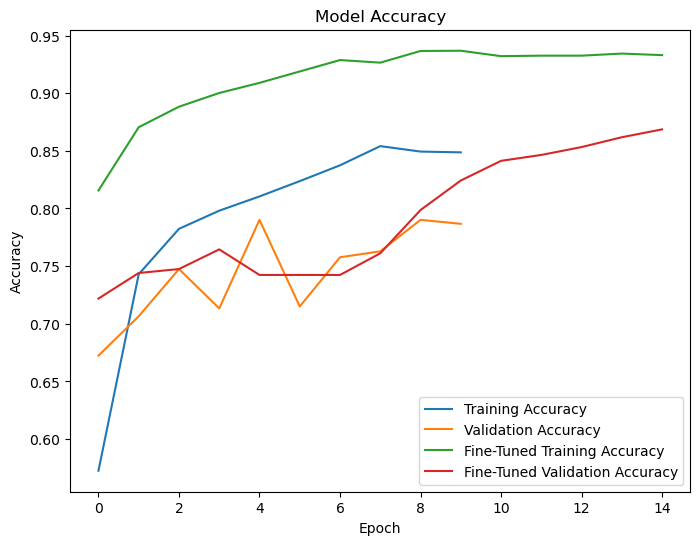

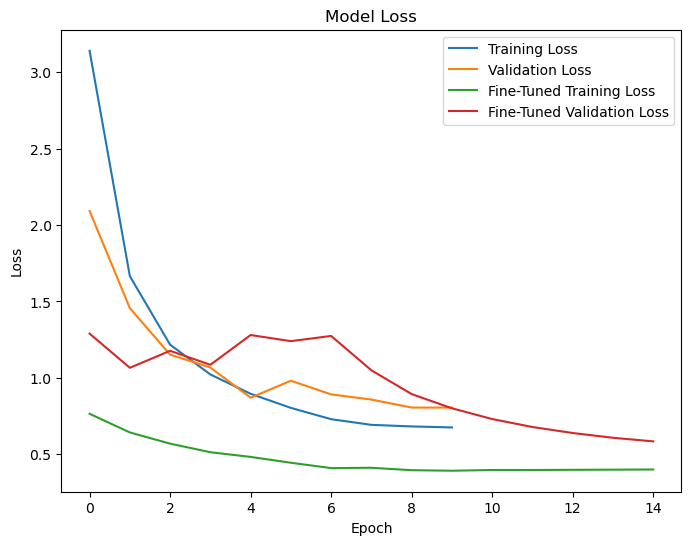

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt

# Define dataset path
dataset_dir = r"C:\Users\Shivani\Downloads\merged_dataset"

# Improved Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'valid'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Build the Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increased L2 regularization
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model (Phase 1 - Adam Optimizer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Increased patience

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    return lr * 0.5

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train Model (Phase 1 - Only Top Layers)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)

# 🔥 **Fine-Tuning: Unfreeze Last 30 Layers**
base_model.trainable = True
for layer in base_model.layers[:-30]:  
    layer.trainable = False

# Compile Again with Adam Optimizer (Higher LR)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model (Phase 2 - Fine-Tuning)
history_fine = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the Model
os.makedirs('models', exist_ok=True)
model.save(os.path.join('models', 'skin_disease_classification_model.h5'))

# Plot Training Results
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('results/accuracy_plot.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('results/loss_plot.png')
plt.show()
